In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Tests to see can fix the OOM problems
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, orbax_utils
import optax
import orbax
import wandb
from tqdm import tqdm

from visualization import visualize as vis
from data import data_functions as df
from models import train_model as trm
from models import generate_model as gen
from models import model_architecture as march

In [2]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, segmentation = self.dataset[idx]
        # Convert data to numpy arrays
        image = np.array(image)
        segmentation = np.array(segmentation)
        return image, segmentation

In [3]:
# Download the dataset with images & segmentations (as labels)
# resize the images & segmentations to be 224x224
train_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                          split='trainval',
                          target_types='segmentation',
                          download=True,
                          transform=transforms.Resize((128, 128)),                   
                          target_transform=transforms.Resize((128, 128)))

# Convert downloaded data to jax compatible datasets/dataloaders
train_set = JaxDataset(dataset=train_set)
train_loader = df.NumpyLoader(dataset=train_set,
                              batch_size=2,
                              shuffle=True)
batch = next(iter(train_loader))

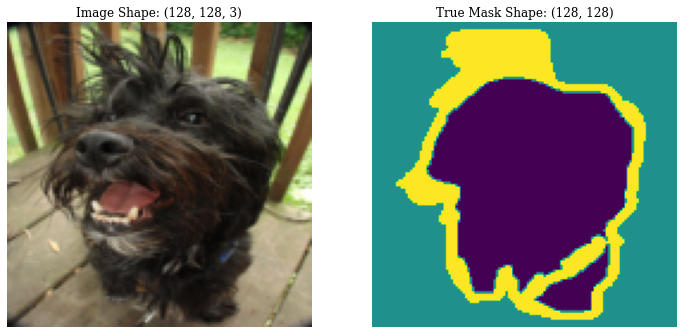

In [4]:
def visualize_sample(batch, idx):
    image, segmentation = batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(image[idx])
    ax1.set_title(f"Image Shape: {image[idx].shape}")
    ax1.axis("off")
    
    ax2.imshow(segmentation[idx])
    ax2.set_title(f"True Mask Shape: {segmentation[idx].shape}")
    ax2.axis("off")
    
    plt.show()

visualize_sample(batch, 1)

In [5]:
def init_train_state(model: Any,
                     random_key: Any,
                     x_shape: tuple,
                     learning_rate: int) -> train_state.TrainState:
    """
    Function to initialize the TrainState dataclass, whcih represents
    the entire training state, including step number, parameteers, and 
    optimizer state. Used in a Flax framework because you no longer need
    to initialize the model again & again with new variables. Rather we 
    just update the "state" of the model and pass this as inputs to functions.
    
    Args:
    -----
        model: nn.Module
            Model we want to train.
        random_key: jax.random.PRNGKey()
            Used to trigger the initialization functions, which generate
            the initial set of parameters that the model will use.
        x_shape: tuple
            Shape of the batch of data (x) that will be input into the model.
            Used to trigger shape inference.

        learning_rate: float
            How large of a step the optimizer should take.
            
    Returns:
    --------
        train_state.TrainState:
            A utility class for handling parameter and gradient updates.
    """
    # Initialize the model
    variables = model.init(random_key, jnp.ones(x_shape))
    
    # Create the optimizer
    optimizer = optax.adam(learning_rate)
    
    # Create a state
    return flax.training.train_state.TrainState.create(apply_fn=model.apply,
                                                       tx=optimizer,
                                                       params=variables['params'])

def train_step(state: train_state.TrainState, batch: jnp.ndarray):
    image, segmentation = batch
    segmentation_shifted = segmentation - 1 # makes it 0 indexed (0,1,2) instead of (1,2,3)
    # Define the loss function
    def loss_fn(params):
        pred = state.apply_fn({'params': params}, image)
        loss = optax.softmax_cross_entropy_with_integer_labels(pred, segmentation_shifted).mean()
        return loss
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

def eval_step(state, batch):
    image, segmentation = batch
    segmentation_shifted = segmentation - 1
    pred = state.apply_fn({'params': state.params}, image)
    return optax.softmax_cross_entropy_with_integer_labels(pred, segmentation_shifted).mean()

def accumulate_metrics(metrics):
    """
    Function that accumulates all the per batch metrics into
    per epoch metrics
    """
    metrics = jax.device_get(metrics)
    return {
        k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]
    }

def save_checkpoint(ckpt_dir: str,
                    state: Any,
                    step: int,
                    wandb_logging: bool = False) -> None:
    """
    Save the training state as a checkpoint

    Args:
    -----
        ckpt_dir: str
            Directory to save the checkpoint files.
        state: Any
            The training state to be saved.
        step: int
            Current training step or epoch number.
        wandb_logging: bool
            If True, uses the wandb run name in the checkpoint filename.
            Default is False.
    """
    ckptr = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())

    # Ensure directory exists
    os.makedirs(ckpt_dir, exist_ok=True)

    # Get the wandb run name or id if wandb logging is enabled
    run_name = wandb.run.name if wandb_logging else ""

    # Create checkpoint file path with the ".flax" extension and the wandb run name if applicable
    ckpt_file = os.path.join(ckpt_dir, f"checkpoint_{run_name}.flax")

    # Save checkpoint to local directory
    ckptr.save(ckpt_file, state,
               save_args=flax.training.orbax_utils.save_args_from_target(state),
               force=True)

    # If wandb logging is enabled, save the checkpoint to wandb run
    if wandb_logging:
        wandb.save(ckpt_file)


def train_model_sweep(train_loader,
                      test_loader,
                      model,
                      state,
                      config,
                      dir_name,
                      project_name,
                      wandb_logging=True):
    """
    Train a machine learning model with optional Weights & Biases (wandb) logging.

    Parameters:
    -----------
    train_loader: 
        A data loader providing the training data.
    model: 
        The model to be trained.
    state: 
        The initial state of the model.
    config: dict
        A dictionary containing configuration parameters for training, such as learning rate, batch size etc.
    wandb_logging: bool
        If True, training progress is logged using wandb.
        Default is False.

    Returns:
    --------
        model: The trained model.
        state: The final state of the model after training.
    """    
    # Initialize a var to hold the best test loss seen so far
    best_test_loss = float('inf')
    
    # Start the training loop
    for epoch in tqdm(range(config['epochs'])):
        # Initialize a list to store all batch-level metrics
        train_batch_metrics = []
        test_batch_metrics = []

        for batch in train_loader:
            # Prepare the data
            batch = jax.device_put(batch)

            # Update the model
            train_step_jit = jax.jit(train_step)
            state, batch_loss = train_step_jit(state, batch)    

            # Store the batch-level metric in the list
            train_batch_metrics.append({'Train Loss': batch_loss})

        # Get the test loss during training
        for batch in test_loader:
            eval_step_jit = jax.jit(eval_step)
            test_batch_loss = eval_step_jit(state, batch)
            test_batch_metrics.append({'Test Loss': test_batch_loss})
            
        # Use accumulate_metrics to calculate average metrics for the epoch
        train_epoch_metrics = accumulate_metrics(train_batch_metrics)
        print('Train Epoch Loss =', train_epoch_metrics)
        test_epoch_metrics = accumulate_metrics(test_batch_metrics)
        print('Test Epoch Loss =', test_epoch_metrics)

        # If the test loss for this epoch is better than the previous best,
        # save the model
        if test_epoch_metrics['Test Loss'] < best_test_loss:
            best_test_loss = test_epoch_metrics['Test Loss'] # Update the best test loss
            checkpt_dir = dir_name # dir where models are saved to
            save_checkpoint(checkpt_dir, state, epoch, project_name)

        # If wandb logging is enabled, log metrics
        if wandb_logging:
            wandb.log(train_epoch_metrics)
            wandb.log(test_epoch_metrics)

    # checkpt_dir = dir_name # dir to save the checkpoints
    # save_checkpoint(checkpt_dir, state, config['epochs'], project_name)

    return model, state

def train_sweep(config=None, project_name='toy_UNet', dir_name='PFGMPP/saved_models/UNET_toy'):
    # Create random PRNG keys for training
    init_rng = random.PRNGKey(0)
    rng, subkey1, subkey2, subkey3 = random.split(init_rng, num=4)

    # Get the absolute path of the saved_models/toy directory
    dir_name = os.path.join(os.path.expanduser('~'), str(dir_name)) #FIX THIS HARDCODE
    
    # If wandb logging is enabled, initialize wandb
    with wandb.init(config=config, dir=dir_name):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        train_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                                  split='trainval',
                                  target_types='segmentation',
                                  download=True,
                                  transform=transforms.Resize((128, 128)),                   
                                  target_transform=transforms.Resize((128, 128)))
        train_set = JaxDataset(dataset=train_set)
        train_loader = df.NumpyLoader(dataset=train_set,
                                      batch_size=config['batch_size'],
                                      shuffle=True)
        train_batch = next(iter(train_loader))

        test_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                                 split='test',
                                 target_types='segmentation',
                                 download=True,
                                 transform=transforms.Resize((128, 128)),
                                 target_transform=transforms.Resize((128, 128)))
        test_set = JaxDataset(dataset=test_set)
        test_loader = df.NumpyLoader(dataset=test_set,
                                     batch_size=config['batch_size'],
                                     shuffle=False)
        
        # Get the rng & model instantiated
        init_rng = random.PRNGKey(config['seed'])
        model = march.UNet(depth=config['depth'],
                     initial_filters=config['initial_filters'],
                     output_channels=config['output_channels'])
        
        # Initialize the models state
        state = init_train_state(model=model,
                                 random_key=init_rng,
                                 x_shape=train_batch[0].shape,
                                 learning_rate=config['learning_rate'])
        
        # Call the training function
        model, state = train_model_sweep(train_loader,
                                         test_loader,
                                         model,
                                         state,
                                         config,
                                         wandb_logging=True,
                                         project_name=project_name,
                                         dir_name=dir_name)


        del state
        del model
        del train_set
        del train_loader
        del test_set
        del test_loader
        wandb.finish()

In [6]:
config = {
    'method': 'random',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'optimizer': {
            'value': 'adam'
        },
        'seed': {
            'value': 10
        },
        'epochs': {
            'value': 30
        },
        'batch_size': {
            'values': [10, 20]
        },
        'learning_rate': {
            'values': [1e-3, 5e-3, 1e-4]
        },
        'depth': {
            'value': 5
        },
        'initial_filters': {
            'values': [32, 64]
        },
        'output_channels': {
            'value': 3
        }
    }
}
import pprint
pprint.pprint(config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [10, 20]},
                'depth': {'value': 5},
                'epochs': {'value': 30},
                'initial_filters': {'values': [32, 64]},
                'learning_rate': {'values': [0.001, 0.005, 0.0001]},
                'optimizer': {'value': 'adam'},
                'output_channels': {'value': 3},
                'seed': {'value': 10}}}


In [7]:
sweep_id = wandb.sweep(config, project='toy_UNET')
wandb.agent(sweep_id, train_sweep, count=3)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: sgmorm54
Sweep URL: https://wandb.ai/mdowicz/toy_UNET/sweeps/sgmorm54


wandb: Agent Starting Run: 5ixsivg8 with config:
wandb: 	batch_size: 20
wandb: 	depth: 5
wandb: 	epochs: 30
wandb: 	initial_filters: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	output_channels: 3
wandb: 	seed: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mdowicz. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch Loss = {'Train Loss': 1.5561697}
Test Epoch Loss = {'Test Loss': 0.71439046}


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
  3%|▎         | 1/30 [00:56<27:30, 56.91s/it]

Train Epoch Loss = {'Train Loss': 0.6871726}
Test Epoch Loss = {'Test Loss': 0.650694}


  7%|▋         | 2/30 [01:34<21:18, 45.67s/it]

Train Epoch Loss = {'Train Loss': 0.6182564}
Test Epoch Loss = {'Test Loss': 0.6230235}


 10%|█         | 3/30 [02:12<18:56, 42.09s/it]

Train Epoch Loss = {'Train Loss': 0.57253474}
Test Epoch Loss = {'Test Loss': 0.55050147}


 13%|█▎        | 4/30 [02:50<17:31, 40.44s/it]

Train Epoch Loss = {'Train Loss': 0.52517915}
Test Epoch Loss = {'Test Loss': 0.5017292}


 17%|█▋        | 5/30 [03:28<16:29, 39.58s/it]

Train Epoch Loss = {'Train Loss': 0.4880068}
Test Epoch Loss = {'Test Loss': 0.50112176}


 20%|██        | 6/30 [04:06<15:35, 38.98s/it]

Train Epoch Loss = {'Train Loss': 0.44761544}
Test Epoch Loss = {'Test Loss': 0.43335208}


 27%|██▋       | 8/30 [05:18<13:40, 37.28s/it]

Train Epoch Loss = {'Train Loss': 0.42047277}
Test Epoch Loss = {'Test Loss': 0.4516056}
Train Epoch Loss = {'Train Loss': 0.41779187}
Test Epoch Loss = {'Test Loss': 0.4113027}


 30%|███       | 9/30 [05:56<13:06, 37.45s/it]

Train Epoch Loss = {'Train Loss': 0.3816906}
Test Epoch Loss = {'Test Loss': 0.40752888}


 33%|███▎      | 10/30 [06:34<12:31, 37.60s/it]

Train Epoch Loss = {'Train Loss': 0.36451107}
Test Epoch Loss = {'Test Loss': 0.39750722}


 40%|████      | 12/30 [07:46<11:00, 36.71s/it]

Train Epoch Loss = {'Train Loss': 0.3554412}
Test Epoch Loss = {'Test Loss': 0.404713}


 43%|████▎     | 13/30 [08:21<10:12, 36.03s/it]

Train Epoch Loss = {'Train Loss': 0.3515133}
Test Epoch Loss = {'Test Loss': 0.4511116}
Train Epoch Loss = {'Train Loss': 0.35596886}
Test Epoch Loss = {'Test Loss': 0.38852862}


 50%|█████     | 15/30 [09:33<08:59, 35.95s/it]

Train Epoch Loss = {'Train Loss': 0.33400825}
Test Epoch Loss = {'Test Loss': 0.39139253}
Train Epoch Loss = {'Train Loss': 0.3406349}
Test Epoch Loss = {'Test Loss': 0.37947783}


 57%|█████▋    | 17/30 [10:45<07:46, 35.90s/it]

Train Epoch Loss = {'Train Loss': 0.33702955}
Test Epoch Loss = {'Test Loss': 0.40759668}


 60%|██████    | 18/30 [11:20<07:05, 35.47s/it]

Train Epoch Loss = {'Train Loss': 0.3298565}
Test Epoch Loss = {'Test Loss': 0.3883471}


 63%|██████▎   | 19/30 [11:54<06:26, 35.17s/it]

Train Epoch Loss = {'Train Loss': 0.31453496}
Test Epoch Loss = {'Test Loss': 0.42334428}


 67%|██████▋   | 20/30 [12:29<05:49, 34.97s/it]

Train Epoch Loss = {'Train Loss': 0.31127125}
Test Epoch Loss = {'Test Loss': 0.38512072}
Train Epoch Loss = {'Train Loss': 0.32093015}
Test Epoch Loss = {'Test Loss': 0.3562866}


 73%|███████▎  | 22/30 [13:41<04:43, 35.47s/it]

Train Epoch Loss = {'Train Loss': 0.30881637}
Test Epoch Loss = {'Test Loss': 0.3840913}


 77%|███████▋  | 23/30 [14:16<04:06, 35.17s/it]

Train Epoch Loss = {'Train Loss': 0.29976746}
Test Epoch Loss = {'Test Loss': 0.36496934}


 80%|████████  | 24/30 [14:50<03:29, 34.97s/it]

Train Epoch Loss = {'Train Loss': 0.28494024}
Test Epoch Loss = {'Test Loss': 0.35764262}


 83%|████████▎ | 25/30 [15:25<02:54, 34.82s/it]

Train Epoch Loss = {'Train Loss': 0.2743386}
Test Epoch Loss = {'Test Loss': 0.36110827}


 87%|████████▋ | 26/30 [15:59<02:18, 34.72s/it]

Train Epoch Loss = {'Train Loss': 0.26828745}
Test Epoch Loss = {'Test Loss': 0.36497903}


 90%|█████████ | 27/30 [16:34<01:43, 34.66s/it]

Train Epoch Loss = {'Train Loss': 0.27935514}
Test Epoch Loss = {'Test Loss': 0.3771529}


 93%|█████████▎| 28/30 [17:08<01:09, 34.60s/it]

Train Epoch Loss = {'Train Loss': 0.24821354}
Test Epoch Loss = {'Test Loss': 0.37457374}


 97%|█████████▋| 29/30 [17:43<00:34, 34.57s/it]

Train Epoch Loss = {'Train Loss': 0.24923706}
Test Epoch Loss = {'Test Loss': 0.38539284}


100%|██████████| 30/30 [18:17<00:00, 36.59s/it]

Train Epoch Loss = {'Train Loss': 0.25293863}
Test Epoch Loss = {'Test Loss': 0.36753306}


Test Loss,█▇▆▅▄▄▃▃▂▂▂▂▃▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▂▁
Train Loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Loss,0.36753
Train Loss,0.25294


wandb: Agent Starting Run: ip79tj13 with config:
wandb: 	batch_size: 10
wandb: 	depth: 5
wandb: 	epochs: 30
wandb: 	initial_filters: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	output_channels: 3
wandb: 	seed: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch Loss = {'Train Loss': 1.367182}
Test Epoch Loss = {'Test Loss': 0.79565364}


  3%|▎         | 1/30 [00:42<20:30, 42.42s/it]

Train Epoch Loss = {'Train Loss': 0.68747854}
Test Epoch Loss = {'Test Loss': 0.6457269}


  7%|▋         | 2/30 [01:15<17:17, 37.05s/it]

Train Epoch Loss = {'Train Loss': 0.56128716}
Test Epoch Loss = {'Test Loss': 0.5463843}


 10%|█         | 3/30 [01:48<15:53, 35.31s/it]

Train Epoch Loss = {'Train Loss': 0.49972436}
Test Epoch Loss = {'Test Loss': 0.4849381}


 13%|█▎        | 4/30 [02:22<14:58, 34.56s/it]

Train Epoch Loss = {'Train Loss': 0.4534046}
Test Epoch Loss = {'Test Loss': 0.4661788}


 17%|█▋        | 5/30 [02:55<14:12, 34.11s/it]

Train Epoch Loss = {'Train Loss': 0.42127776}
Test Epoch Loss = {'Test Loss': 0.438309}


 23%|██▎       | 7/30 [04:01<12:48, 33.40s/it]

Train Epoch Loss = {'Train Loss': 0.3889811}
Test Epoch Loss = {'Test Loss': 0.46086532}
Train Epoch Loss = {'Train Loss': 0.3611466}
Test Epoch Loss = {'Test Loss': 0.4115987}


 27%|██▋       | 8/30 [04:34<12:14, 33.37s/it]

Train Epoch Loss = {'Train Loss': 0.33548713}
Test Epoch Loss = {'Test Loss': 0.40360254}


 33%|███▎      | 10/30 [05:40<11:02, 33.11s/it]

Train Epoch Loss = {'Train Loss': 0.3331094}
Test Epoch Loss = {'Test Loss': 0.40779075}
Train Epoch Loss = {'Train Loss': 0.29690948}
Test Epoch Loss = {'Test Loss': 0.40282097}


 40%|████      | 12/30 [06:46<09:53, 32.99s/it]

Train Epoch Loss = {'Train Loss': 0.28087577}
Test Epoch Loss = {'Test Loss': 0.40660614}


 43%|████▎     | 13/30 [07:19<09:18, 32.85s/it]

Train Epoch Loss = {'Train Loss': 0.26533702}
Test Epoch Loss = {'Test Loss': 0.43635905}


 47%|████▋     | 14/30 [07:51<08:44, 32.77s/it]

Train Epoch Loss = {'Train Loss': 0.2620964}
Test Epoch Loss = {'Test Loss': 0.4321266}


 50%|█████     | 15/30 [08:24<08:10, 32.71s/it]

Train Epoch Loss = {'Train Loss': 0.24026345}
Test Epoch Loss = {'Test Loss': 0.41614234}


 53%|█████▎    | 16/30 [08:56<07:37, 32.69s/it]

Train Epoch Loss = {'Train Loss': 0.22329044}
Test Epoch Loss = {'Test Loss': 0.4208221}


 57%|█████▋    | 17/30 [09:29<07:04, 32.64s/it]

Train Epoch Loss = {'Train Loss': 0.21153508}
Test Epoch Loss = {'Test Loss': 0.42188856}


 60%|██████    | 18/30 [10:01<06:31, 32.61s/it]

Train Epoch Loss = {'Train Loss': 0.22332431}
Test Epoch Loss = {'Test Loss': 0.43071228}


 63%|██████▎   | 19/30 [10:34<05:58, 32.59s/it]

Train Epoch Loss = {'Train Loss': 0.19695821}
Test Epoch Loss = {'Test Loss': 0.43891826}


 67%|██████▋   | 20/30 [11:06<05:25, 32.58s/it]

Train Epoch Loss = {'Train Loss': 0.195395}
Test Epoch Loss = {'Test Loss': 0.43479815}


 70%|███████   | 21/30 [11:39<04:53, 32.57s/it]

Train Epoch Loss = {'Train Loss': 0.19128227}
Test Epoch Loss = {'Test Loss': 0.45215815}


 73%|███████▎  | 22/30 [12:12<04:20, 32.56s/it]

Train Epoch Loss = {'Train Loss': 0.17374782}
Test Epoch Loss = {'Test Loss': 0.47864592}


 77%|███████▋  | 23/30 [12:44<03:47, 32.56s/it]

Train Epoch Loss = {'Train Loss': 0.16353397}
Test Epoch Loss = {'Test Loss': 0.4769796}


 80%|████████  | 24/30 [13:17<03:15, 32.57s/it]

Train Epoch Loss = {'Train Loss': 0.15862201}
Test Epoch Loss = {'Test Loss': 0.5492147}


 83%|████████▎ | 25/30 [13:49<02:42, 32.56s/it]

Train Epoch Loss = {'Train Loss': 0.15549438}
Test Epoch Loss = {'Test Loss': 0.5161454}


 87%|████████▋ | 26/30 [14:22<02:10, 32.56s/it]

Train Epoch Loss = {'Train Loss': 0.15016057}
Test Epoch Loss = {'Test Loss': 0.54798913}


 90%|█████████ | 27/30 [14:55<01:37, 32.59s/it]

Train Epoch Loss = {'Train Loss': 0.1555793}
Test Epoch Loss = {'Test Loss': 0.47093508}


 93%|█████████▎| 28/30 [15:27<01:05, 32.57s/it]

Train Epoch Loss = {'Train Loss': 0.2053177}
Test Epoch Loss = {'Test Loss': 0.43583784}


 97%|█████████▋| 29/30 [16:00<00:32, 32.56s/it]

Train Epoch Loss = {'Train Loss': 0.15124439}
Test Epoch Loss = {'Test Loss': 0.5055088}


100%|██████████| 30/30 [16:32<00:00, 33.09s/it]

Train Epoch Loss = {'Train Loss': 0.13039465}
Test Epoch Loss = {'Test Loss': 0.5800644}


Test Loss,█▅▄▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▂▂▂▂▂▄▃▄▂▂▃▄
Train Loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Test Loss,0.58006
Train Loss,0.13039


wandb: Agent Starting Run: 75fnvisc with config:
wandb: 	batch_size: 20
wandb: 	depth: 5
wandb: 	epochs: 30
wandb: 	initial_filters: 32
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	output_channels: 3
wandb: 	seed: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/30 [00:16<?, ?it/s]
